In [1]:
import torch
import numpy as np
import karuiflow as kf
import os
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Defining a neural network class

In [24]:
class Linear(kf.nn.Module):
    def __init__(self, dim1, dim2):
        super().__init__()
        value = np.random.randn(dim1, dim2).astype('float32') / np.sqrt(dim1)
        self.weights = kf.core.Parameter(value)
        
    def forward(self, x):
        return kf.matmul(x, self.weights)
    

class LinearReLU(kf.nn.Module):
    def __init__(self, dim1, dim2):
        super().__init__()
        self.linear = Linear(dim1, dim2)
        
    def forward(self, x):
        x = self.linear(x)
        return kf.relu(x)
    
class NN(kf.nn.Module):
    def __init__(self, in_dim, dim=128, n_classes=10):
        super().__init__()
        self.layer1 = LinearReLU(in_dim, 123)
        self.layer2 = LinearReLU(123, 125)
        self.layer3 = Linear(125, n_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)        
        x = self.layer3(x)
        return kf.softmax(x)

In [25]:
nn = NN(28 * 28)

## Training

In [28]:
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [39]:
indices = np.arange(BATCH_SIZE)

# Cross-entropy
def loss_fn(x, y, nn, n_classes=10):
    x = kf.tensor(x).to('cuda', inplace=True)
    y_pred = nn(x)
    log_pred = kf.log(y_pred)
    one_hot = np.zeros((BATCH_SIZE, n_classes), dtype='float32')
    one_hot[indices, y] = 1.
    one_hot = kf.tensor(one_hot).to('cuda', inplace=True)
    return kf.sum(log_pred * one_hot, dim=[0, 1]) * -1. 

In [40]:
def preprocess(im):
    im = np.asarray(im, dtype='float32').reshape(-1) / 127 - 1
    return im

In [41]:
# Hyper parameters
BATCH_SIZE = 128
EPOCHS = 3
optim = kf.optim.SGD(nn.parameters(), lr=1e-3, momentum=0.9)

In [42]:
# Dataset
mnist_train = MNIST(root='.', train=True, download=True, transform=lambda x: preprocess(x))
mnist_train = DataLoader(mnist_train, batch_size=BATCH_SIZE)

In [43]:
# Move all network's weight to cuda gpu
nn.to('cuda')

In [44]:
for epoch in range(EPOCHS):
    for i, (im, label) in enumerate(mnist_train):
        if len(label) != BATCH_SIZE:
            break
            
        loss = loss_fn(im.numpy(), label.numpy(), nn)
        loss.backward()
        optim.step()
        optim.zero_grad()

        if i % 50 == 0:
            print('Epoch:', epoch, 'Iteration:', i, 'Loss:', loss.numpy())

Epoch: 0 Iteration: 0 Loss: 307.56183
Epoch: 0 Iteration: 50 Loss: 63.857635
Epoch: 0 Iteration: 100 Loss: 57.446358
Epoch: 0 Iteration: 150 Loss: 42.459236
Epoch: 0 Iteration: 200 Loss: 28.486177
Epoch: 0 Iteration: 250 Loss: 45.721684
Epoch: 0 Iteration: 300 Loss: 45.47805
Epoch: 0 Iteration: 350 Loss: 52.888504
Epoch: 0 Iteration: 400 Loss: 56.23818
Epoch: 0 Iteration: 450 Loss: 35.27683
Epoch: 1 Iteration: 0 Loss: 13.303685
Epoch: 1 Iteration: 50 Loss: 24.778011
Epoch: 1 Iteration: 100 Loss: 28.226936
Epoch: 1 Iteration: 150 Loss: 17.354359
Epoch: 1 Iteration: 200 Loss: 18.025667
Epoch: 1 Iteration: 250 Loss: 27.962133
Epoch: 1 Iteration: 300 Loss: 20.925299
Epoch: 1 Iteration: 350 Loss: 34.988167
Epoch: 1 Iteration: 400 Loss: 43.795437
Epoch: 1 Iteration: 450 Loss: 24.033047
Epoch: 2 Iteration: 0 Loss: 10.506221
Epoch: 2 Iteration: 50 Loss: 19.584167
Epoch: 2 Iteration: 100 Loss: 15.904536
Epoch: 2 Iteration: 150 Loss: 17.589802
Epoch: 2 Iteration: 200 Loss: 15.049864
Epoch: 2 Ite

## Testing

In [49]:
import matplotlib.pyplot as plt

In [56]:
mnist_test = MNIST(root='.', train=False, download=True, transform=lambda x: preprocess(x))

In [57]:
mnist_test = DataLoader(mnist_test, batch_size=BATCH_SIZE)

In [58]:
im, label = next(iter(mnist_test))
im, label = im.numpy(), label.numpy()

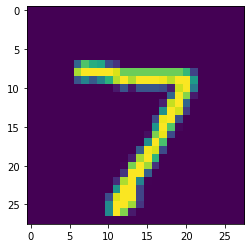

In [59]:
plt.imshow(im[0].reshape(28, 28))

In [60]:
nn.to('cpu')

In [62]:
nn(im[0][None, ...]).numpy().argmax(axis=-1)

array([7], dtype=int64)

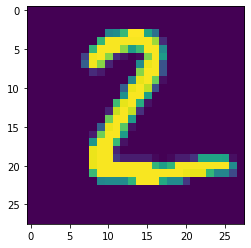

In [63]:
plt.imshow(im[1].reshape(28, 28))

In [64]:
nn(im[1][None, ...]).numpy().argmax(axis=-1)

array([2], dtype=int64)

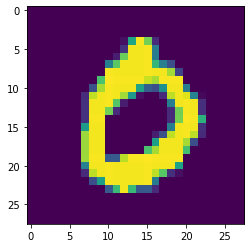

In [65]:
plt.imshow(im[3].reshape(28, 28))

In [60]:
nn.to('cpu')

In [66]:
nn(im[3][None, ...]).numpy().argmax(axis=-1)

array([0], dtype=int64)